# Multi Task Model

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Tensorflow imports
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import ResNet50

from loadData_alt import createDataset

## Model parameters

In [2]:
# Log parameters
model_name = 'mtm_classification_ds'
savedModelPath = f'../../log/saved_models/{model_name}'
tb_log_dir = f'../../log/tensorboard/{model_name}'
cp_filepath = f'../../log/cps/{model_name}/'

if not os.path.exists(cp_filepath):
    os.makedirs(cp_filepath)

cp_filepath += 'latest_weights.h5'

# Dynamic hyperparameters
learningRate = 0.001
doDataAugmentation = True
doFineTuning = False
dropoutRate = 0.25
width_multiplier = 1
depth_multiplier = 1

# Training parameters
batch_size = 32
epochs = 5

## Model callbacks

In [3]:
callbacks = [
    # Checkpoint callback                    
    keras.callbacks.ModelCheckpoint(
                    filepath=cp_filepath, 
                    verbose=1, 
                    save_weights_only=True),

    # Tensorboard callback
    keras.callbacks.TensorBoard(log_dir=tb_log_dir, histogram_freq=1),

    # Early Stopping callback
    # keras.callbacks.EarlyStopping(
    #                 monitor="val_loss",
    #                 patience=2,
    #                 verbose=1)
]

## Data parameters

In [4]:
image_height = 160
image_width = 160

use_age_groups = True
num_age_classes = 8 if use_age_groups else 122

age_classes_dict = {
    0 : "0-13",
    1 : "14-19",
    2 : "20-29",
    3 : "30-39",
    4 : "40-49",
    5 : "50-59",
    6 : "60+",
    7 : "-"
}

## Data Augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomBrightness(0.2),
    ]
)

## Creating the training datasets

In [6]:
training_ds, validation_ds = createDataset('../../data/m3/training', (image_height, image_width), batch_size, 0.2, use_age_groups=use_age_groups)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Creating the test dataset

In [7]:
#test_ds = createDataset('../../data/m3/training', batch_size, 0)

## Load the ResNet model

In [8]:
# Loading either the MobileNet architecture model or the previously saved model, and freeze it for transfer learning
base = ResNet50(
                input_shape=(image_height, image_width, 3), # Optional shape tuple, only to be specified if include_top is False
                # alpha=width_multiplier, # Controls the width of the network. (Width multiplier)
                # depth_multiplier=depth_multiplier, # Depth multiplier for depthwise convolution. (Resolution multiplier)
                # dropout=dropoutRate, # Dropout rate. Default to 0.001.
                weights="imagenet",
                # input_tensor=None,
                # pooling='avg', # Optional pooling mode for feature extraction when include_top is False. (None, avg, max)
                include_top=False
                )
           
# Freeze the base model
base.trainable = False

inputs = keras.Input(shape=(image_height, image_width, 3))
# Data Augmentation on input
if(doDataAugmentation):
    inputs = data_augmentation(inputs)

# Running base model in inference mode
base_model = base(inputs, training=False)
base_model = keras.layers.GlobalAveragePooling2D()(base_model)
base_model = keras.layers.Dense(1024)(base_model)
base_model = keras.layers.Dropout(0.3)(base_model)

## Creating Task 1 (Face Detection) Top Model

In [9]:
# Add Dense layer
face_head = tf.keras.layers.Dense(256, activation='relu')(base_model)
face_head = keras.layers.BatchNormalization()(face_head)
face_head = keras.layers.Activation('relu')(face_head)
face_head = keras.layers.Dropout(0.2)(face_head)
face_head = tf.keras.layers.Dense(128, activation='relu')(face_head)
face_head = tf.keras.layers.Dense(64, activation='relu')(face_head)

# Final layer for binary classification
face_outputs = keras.layers.Dense(1, activation='sigmoid', name='face_output')(face_head)


## Creating Task 2 (Mask Detection) Top Model

In [10]:
# Add Dense layer
mask_head = tf.keras.layers.Dense(256, activation='relu')(base_model)
mask_head = keras.layers.BatchNormalization()(mask_head)
mask_head = keras.layers.Activation('relu')(mask_head)
mask_head = keras.layers.Dropout(0.2)(mask_head)
mask_head = tf.keras.layers.Dense(128, activation='relu')(mask_head)
mask_head = tf.keras.layers.Dense(64, activation='relu')(mask_head)

# Final layer for binary classification
mask_outputs = keras.layers.Dense(1, activation='sigmoid', name='mask_output')(mask_head)

## Creating Task 3 (Age Prediction) Top Model

In [11]:
# Add Dense layer
age_head = tf.keras.layers.Dense(256, activation='relu')(base_model)
age_head = keras.layers.BatchNormalization()(age_head)
age_head = keras.layers.Activation('relu')(age_head)
age_head = keras.layers.Dropout(0.2)(age_head)
age_head = tf.keras.layers.Dense(128, activation='relu')(age_head)
age_head = tf.keras.layers.Dense(64, activation='relu')(age_head)

# Final layer for binary classification
age_outputs = keras.layers.Dense(num_age_classes, activation='softmax', name='age_output')(age_head)

In [12]:
age_class_weights = np.ones((num_age_classes, num_age_classes), dtype=np.float32)
age_class_weights[:, num_age_classes-1] = 0.0 # Last class will be ignored (invalid data)
age_class_weights[num_age_classes-1, :] = 0.0 # Last class will be ignored (invalid data)

print(age_class_weights)
def WeightedCategoricalCrossentropy(y_true, y_pred):
    nb_cl = len(age_class_weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.equal(y_pred, y_pred_max)
    y_pred_max_mat = tf.where(y_pred_max_mat, 1.0, 0.0)
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (age_class_weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    return K.categorical_crossentropy(y_pred, y_true) * final_mask


[[1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


## Creating and compiling the final model

In [13]:

model = keras.Model(inputs, [face_outputs, mask_outputs, age_outputs])
#keras.utils.plot_model(model)

# Using a joint loss function for the three tasks:
# [ Loss = gamma * Loss_task1 + gamma * Loss_task2 + gamma * Loss_task3 ]
# Because every task is dependant on every other task, the model receives the loss of every task when gamma > 0

gamma = 1

model.compile(
      optimizer=keras.optimizers.Adam(0.01), # Learning Rate?
            loss={
                  'face_output': 'binary_crossentropy', 
                  'mask_output': 'binary_crossentropy',
                  'age_output': 'categorical_crossentropy'
                  },
            loss_weights={
                  'face_output': 0.33 * gamma, 
                  'mask_output': 0.33 * gamma,
                  'age_output': 0.33 * gamma
                  }, 
            metrics={
                  'face_output': 'accuracy', 
                  'mask_output': 'accuracy',
                  'age_output': 'accuracy'
                  },
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 5, 5, 2048)   23587712    ['input_3[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[1][0]']               
 alAveragePooling2D)                                                                              
                                                                                              

## Training the model with the dataset

In [14]:
history = model.fit(
            training_ds,
            validation_data=validation_ds,
            epochs=epochs, 
            callbacks=callbacks,
            shuffle=True
        )

Epoch 1/5
425/425 [==============================] - ETA: 0s - loss: 0.2989 - face_output_loss: 0.0304 - mask_output_loss: 0.0242 - age_output_loss: 0.8512 - face_output_accuracy: 0.9912 - mask_output_accuracy: 0.9912 - age_output_accuracy: 0.6606
Epoch 1: saving model to ../../log/cps/mtm_classification_ds\latest_weights.h5
425/425 [==============================] - 422s 807ms/step - loss: 0.2989 - face_output_loss: 0.0304 - mask_output_loss: 0.0242 - age_output_loss: 0.8512 - face_output_accuracy: 0.9912 - mask_output_accuracy: 0.9912 - age_output_accuracy: 0.6606 - val_loss: 0.3178 - val_face_output_loss: 0.0057 - val_mask_output_loss: 0.0957 - val_age_output_loss: 0.8617 - val_face_output_accuracy: 0.9982 - val_mask_output_accuracy: 0.9885 - val_age_output_accuracy: 0.6720
Epoch 2/5
425/425 [==============================] - ETA: 0s - loss: 0.2633 - face_output_loss: 0.0135 - mask_output_loss: 0.0077 - age_output_loss: 0.7768 - face_output_accuracy: 0.9971 - mask_output_accuracy: 0

## Fine tuning

In [ ]:
if doFineTuning:
      model_name = model_name + '_ft'
      base.trainable = True

      model.compile(
            optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
            loss={
                  'face_output': 'binary_crossentropy', 
                  'mask_output': 'binary_crossentropy',
                  'age_output': 'categorical_crossentropy'
                  },
            loss_weights={
                  'face_output': 0.33 * gamma, 
                  'mask_output': 0.33 * gamma,
                  'age_output': 0.33 * gamma
                  }, 
                  metrics=['accuracy']
      )

      model.fit(training_ds, epochs=epochs)

## Save the model

In [15]:
model.save(savedModelPath)

INFO:tensorflow:Assets written to: ../../log/saved_models/mtm_classification_ds\assets


INFO:tensorflow:Assets written to: ../../log/saved_models/mtm_classification_ds\assets


## Test model with test dataset

In [ ]:
#results = model.evaluate(test_ds)

#print(f'Loss: {results[0]}; Accuracy: {results[1]}')

In [ ]:
loaded_model = keras.models.load_model('../../log/saved_models/mtm_classification_ds/')

## Predict new images

1/1 [==============================] - 0s 63ms/step


Text(0.5, 1.0, 'Face: 99.78% | Mask: 81.75% | Age: 20-29 (Actual: 34)')

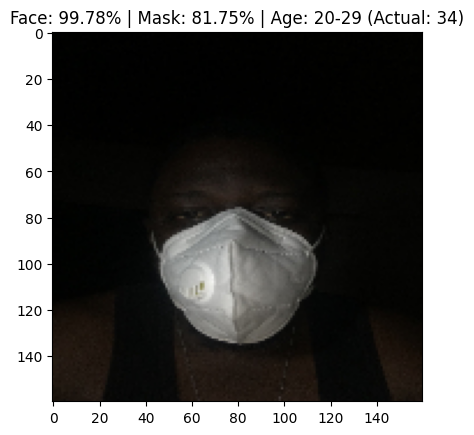

In [42]:
# https://www.tensorflow.org/tutorials/images/classification

img_path = '../../data/m3/training/face/mask/1_1_34_900187.jpg'
img_path_split = img_path.split('/')
img_name = img_path_split[len(img_path_split)-1]
img_name_split = img_name.split('_')
face_actual = img_name_split[0]
mask_actual = img_name_split[1]
age_actual = img_name_split[2]

img = tf.keras.utils.load_img(
    img_path, target_size=(image_height, image_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array_batch = tf.expand_dims(img_array, 0) # Create a batch

preds = loaded_model.predict(img_array_batch)
age_output_indexes = np.array([i for i in range(0, num_age_classes)])

face_pred_percent = preds[0][0][0]*100
mask_pred_percent = preds[1][0][0]*100
age_preds = preds[2][0]
apparent_predictions = np.sum(age_preds * age_output_indexes)

if use_age_groups:
    age_pred = age_classes_dict[np.argmax(age_preds)]
else:
    age_pred = np.argmax(age_preds)

ax = plt.subplot(1, 1, 1)
plt.imshow(img)
plt.title("Face: {:.2f}% | Mask: {:.2f}% | Age: {} (Actual: {})".format(face_pred_percent, mask_pred_percent, age_pred, age_actual))